In [1]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from local_functions import *
import random

# First simulation 🐜
For the first simulation, I try to reproduce some results from Chandrasekhar et al. (2018). 

## 1. Setup
I setup an `AntNetwork` with the same initial setup as Chandrasekhar et al. (2018): 
* an 11x11 grid in which all edges have identical lengths, 
* two nests (one on the center-left and one on the center-right),
* a pheromone path between the nests with 10 units of pheromone on each edge,
* one edge missing in the middle of the pheromone path, and
* 100 ants distributed uniformly at random on the pheromone path.

In [2]:
# initialize AntNetwork
el = 11
g = spatial_lattice_graph(lattice=(el,el))
an = AntNetwork(graph=g)

# add nests at center-left and center-right
an.add_nest(int(el/2))
an.add_nest(int((el*el)-el/2))
an.update_selfedge_visibility()

# initialize pheromone specifically on middle path
an.initialize_pheromone(degree=1, amount=10)

# initialize temporal graph with perturbation in the middle
an.make_invisible(60,71)

# add 100 ants
visible_edges_with_pheromone = [e for e in an.edges() 
                                if (an[e[0]][e[1]]['is_visible'] and
                                    an[e[0]][e[1]]['pheromone'])]
for i in range(100):
    e = random.choice(visible_edges_with_pheromone)
    an.add_new_ants(e[0],e[1],1)

This is what the network looks like when we indicate the pheromone path by blue edges. (We don't show the ants in this visualization.)

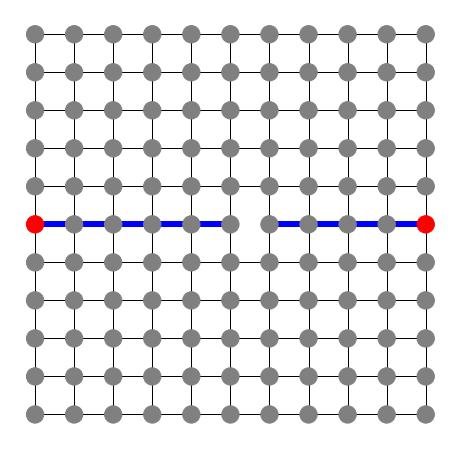

In [3]:
# draw network
plt.figure(figsize=(8,8))
plt.subplot(111)
pos = {i: an.nodes[i]['position'] for i in range(an.number_of_nodes())} # node positions
utg = nx.Graph(an.get_temporal_graph()) # undirected temporal graph
nx.draw(utg, pos, edges=utg.edges(), 
        edge_color=color_edges(utg, pheromone='blue'),
        width=thicken_edges(utg, max_width=6, max_val=10),
        node_color=color_nodes(an))

## 2. Simulation
I now run a simulation for 1000 time steps. Pheromone decays with a decay rate $q_{\textrm{decay}}=0.02$. I use `rankEdge` (called `maxRankEdge` in Chandrasekhar et al. (2018)) with $q_{\textrm{explore}}=0.2$ as the algorithm that ants use to select their route. The only difference between the algorithm used here and in Chandrasekhar et al. (2018) is that I have not implemented "additional technical detail 3" (see page 16 in Chandrasekhar et al. (2018)):

>When turtle ants take an explore step, they often traverse an edge for a short distance, and then return to the original node. This builds a slight extension off the primary path, which can be extended by subsequent
ants. In all algorithms, if a simulated ant takes an explore step, it goes across the edge and comes back
in one time-step. Thus, two units of pheromone are left on the edge, and the ant is back at the node it
started from. (R3-27) An explore step is defined as any choice that cannot occur unless qexplore > 0. [...] for RankEdge, this involves taking an edge that does not have the highest weight.

I will discuss why I have not implemented this detail in the discussion below. 

Let me first show the simulated `AntNetwork` at 25 points in time.

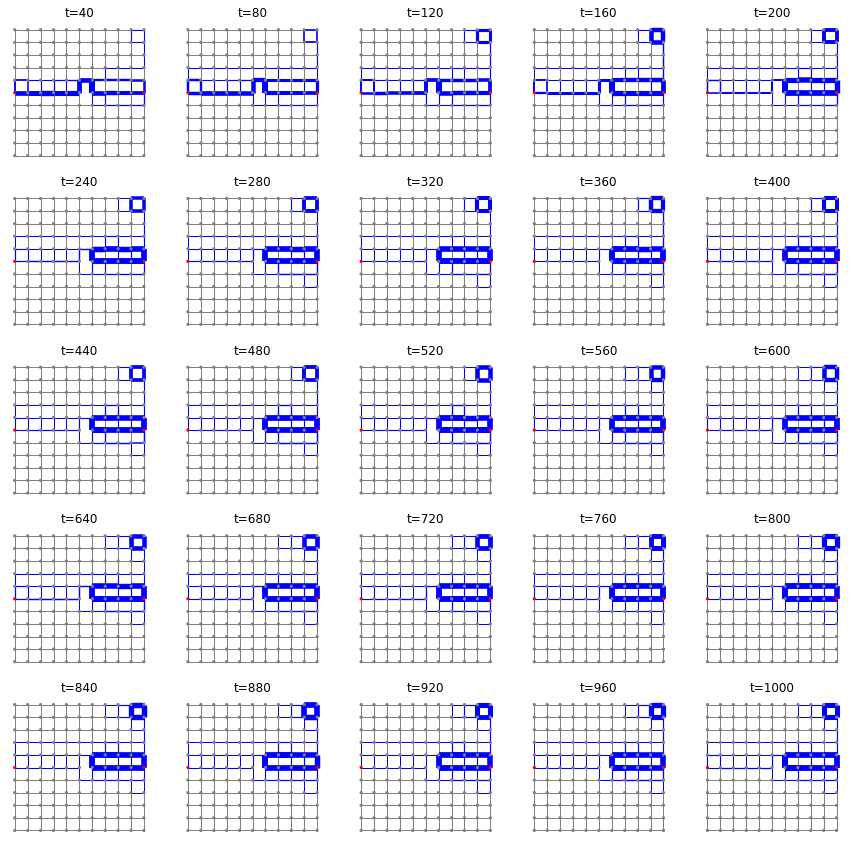

In [4]:
# get a copy of the AntNetwork above
an2 = an.hard_copy()

# setup new figure
plt.figure(figsize=(15,15))

# set parameters
snap=40 # time interval at which we take snap shots
q_decay = 0.02 # decay rate of pheromon
num_timesteps = 25*snap + 1 #total number of time steps in simulation

# use algorithm as describes in Chandrasekhar et al 2018
alg = lambda x: noisyRankEdge_probabilities(x, 0.02, noise=0.0)

# run simulation
for i in range(num_timesteps):
    # move ants
    an2.move_ants(algorithm = alg) 
    # let pheromone decay
    an2.pheromone_decay(q_decay)
    
    if i > 0 and not (i % snap):
        plt.subplot(5,5,int(i/snap))
        plt.title('t='+str(i))
        # get undirected temporal graph
        utg = nx.Graph(an2.get_temporal_graph())
        nx.draw(utg, pos, edges=utg.edges(), 
                edge_color=color_edges(utg, other='grey', pheromone='blue'),
                width=thicken_edges(utg, max_width=6),
                node_color=color_nodes(an2), node_size=5)

## 3. Observations

You can rerun the simulation to see that results vary strongly for different runs. However, there are some obesrvations that hold for most runs:

1. Pheromone paths converge very quickly to a stationary pattern on the lattice. For manby runs, the pheromone paths do not change anymore after the first 200-400 time steps.
2. The stationary pheromone pattern tends to include loops on which (presumably) ants just run around in a circle without ever travelling from one nest to the other. Loops seem more likely to occur at nests or in one of the four corners of the lattice than in other places on the lattice.
3. The stationary pheromone pattern can include a path between the two nests, but in most cases, it does not.

## 4. Discussion

The observations above are very different from the results reported in Chandrasekhar et al. (2018). This indicates that the technical detail that I did not implement crucially affects the system. I did not implement this detail because it seems fundamentally at odds with the phenomena that I would like to investigate; the existence of multiple paths before convergence to a single path. Observations (e.g. in Gordon (2017) Fig. 3A) indicate that before an ant colony converges to using a single path between two nests, there can be a time interval during which several paths (or one "loopy" path) are used by ants. Technical detail 3 in Chandrasekhar et al. (2018) assigns very different behaviour to ants that decide to move along the edge with the largest amount of pheromone than to ants that decide to move along the edge with second-largest amount of pheromone (even if both edges have almost the same amount of pheromone). It forces ants that move along an edge with the second-largest amount to return to the previous node. This means that, even if there are two nest-connecting paths with roughly the same amount of pheromone on their edges, one of them will not be used for transport between nests at all. 

To illustrate this, consider a case where there are two paths, $p_A$  and $p_B$, that connect the two nests (see figure below.) If the first and the last edge of $p_A$ each have slightly more pheromone than the first and large edge of $p_B$ (respectively), then ants will not use $p_B$. Moreover, they can only travel along the first and the last edge of $p_B$ and never on other edges of $p_B$ because they are forced to return to the respective nests after taking an "explore" step along $p_B$. 

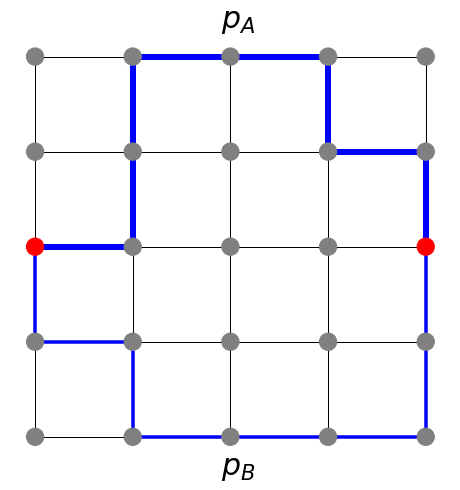

In [22]:
an3 = AntNetwork(graph=spatial_lattice_graph(lattice=(5,5)))
an3.set_nests([2,22])
path1_edges = [(2,7),(7,8),(8,9),(9,14),(14,19),(19,18),(18,23),(23,22)]
path2_edges = [(2,1),(1,6),(6,5),(5,10),(10,15),(15,20),(20,21),(21,22)]
an3.set_pheromone(dict(zip(path1_edges, [2]*len(path1_edges))))
an3.set_pheromone(dict(zip(path2_edges, [1]*len(path2_edges))), empty_canopy=False)

# draw network
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.text(0.475,1.075,'$p_A$', size=30)
ax.text(0.475,-0.1,'$p_B$', size=30)
pos = {i: an3.nodes[i]['position'] for i in range(an3.number_of_nodes())}
utg = nx.Graph(an3.get_temporal_graph())
nx.draw(utg, pos, edges=utg.edges(), 
        edge_color=color_edges(utg, pheromone='blue'),
        width=thicken_edges(utg, max_width=6, max_val=2),
        node_color=color_nodes(an3))


In conclusion, the `maxRankEdge` algorithm that Chandrasekhar et al. (2018) proposed to model the navigation behaviour of arboreal turtle ants strictly forbids that ant colonies to use more than one path to travel between nests at a given point in time. It is thus not suitable for studying the potential transient redundancy in trail networks. Omitting technical detail 3 from `maxRankEdge` leads to an algorithm that - in theory - allows ant colonies to use more than path to conduct transport between nests. However, this modification of the `maxRankEdge` algorithm leads to very different results in simulations. In particular, most simulations lead to trail networks that do not include a path between the two nests. The modified algorithm thus fails to reproduce the convergence of trail networks to a path that connects the colony's nests.

For the study of trail redundancy, I need a different routing algorithm to `maxRankEdge` from Chandrasekhar et al. (2018) and also different to the modified `maxRankEdge` algorithm that I considered in this notebook.